<a href="https://colab.research.google.com/github/vallimeenaa9/Breast_Cancer/blob/main/VGG16_Transfer_model_standalone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Cancer_PNG.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from keras.models import Sequential,Model
from keras.applications.vgg16 import preprocess_input,VGG16
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Flatten,Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from keras.utils.vis_utils import plot_model
import ipywidgets as widgets
from sklearn.preprocessing import OneHotEncoder
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from glob import glob
from tifffile import imread, imwrite
from skimage.transform import resize

In [ ]:
len(os.listdir('/tmp/Cancer_PNG/'))

4

In [ ]:
# Prepere data
benign = os.listdir('/tmp/Cancer_PNG/Benign')
insitu  = os.listdir('/tmp/Cancer_PNG/InSitu')
invasive  = os.listdir('/tmp/Cancer_PNG/Invasive')
normal  = os.listdir('/tmp/Cancer_PNG/Normal')



In [ ]:
# Prepere input data
X_data =[]
for file in benign:
    img = cv2.imread('/tmp/Cancer_PNG/Benign/'+file)
    face = cv2.resize(img, (224, 224) )
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    X_data.append(img)

for file in insitu:
    img = cv2.imread('/tmp/Cancer_PNG/InSitu/'+file)
    face = cv2.resize(img, (224, 224) )
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    X_data.append(img)
  
for file in invasive:
    img = cv2.imread('/tmp/Cancer_PNG/Invasive/'+file)
    face = cv2.resize(img, (224, 224) )
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    X_data.append(img)

for file in normal:
    img = cv2.imread('/tmp/Cancer_PNG/Normal/'+file)
    face = cv2.resize(img, (224, 224) )
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    X_data.append(img)

In [ ]:
X = np.squeeze(X_data)
X.shape

(400, 224, 224, 3)

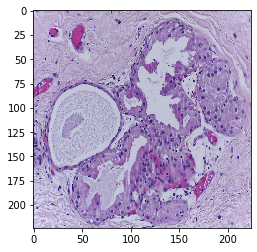

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(X[5], interpolation='nearest')
plt.show()

In [ ]:
target_benign=np.full(len(benign),3)
target_insitu=np.full(len(insitu),2)
target_invasive=np.full(len(invasive),1)
target_normal=np.full(len(normal),0)
Y=np.concatenate([target_benign,target_insitu,target_invasive,target_normal])
Y

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [ ]:
len(Y)

400

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle='true')
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]
print('number_of_train:', number_of_train)
print('number_of_test:', number_of_test)

number_of_train: 320
number_of_test: 80


# Transfer learning

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
early_stop=EarlyStopping(patience=4)
reduceLR=ReduceLROnPlateau(patience=4)

In [ ]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.54.134.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.54.134.114:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
with tpu_strategy.scope():
    vgg_model = VGG16(weights='imagenet',include_top=False)
    for layers in vgg_model.layers:
        layers.trainable=False
    x=vgg_model.output
    data_augmentation
    x=GlobalAveragePooling2D()(x)
    x=Dense(128,activation='relu')(x)
    x=Dropout(0.15)(x)
    output=Dense(4,activation='softmax')(x)
    model2=Model(inputs=vgg_model.input,outputs=output)
    model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

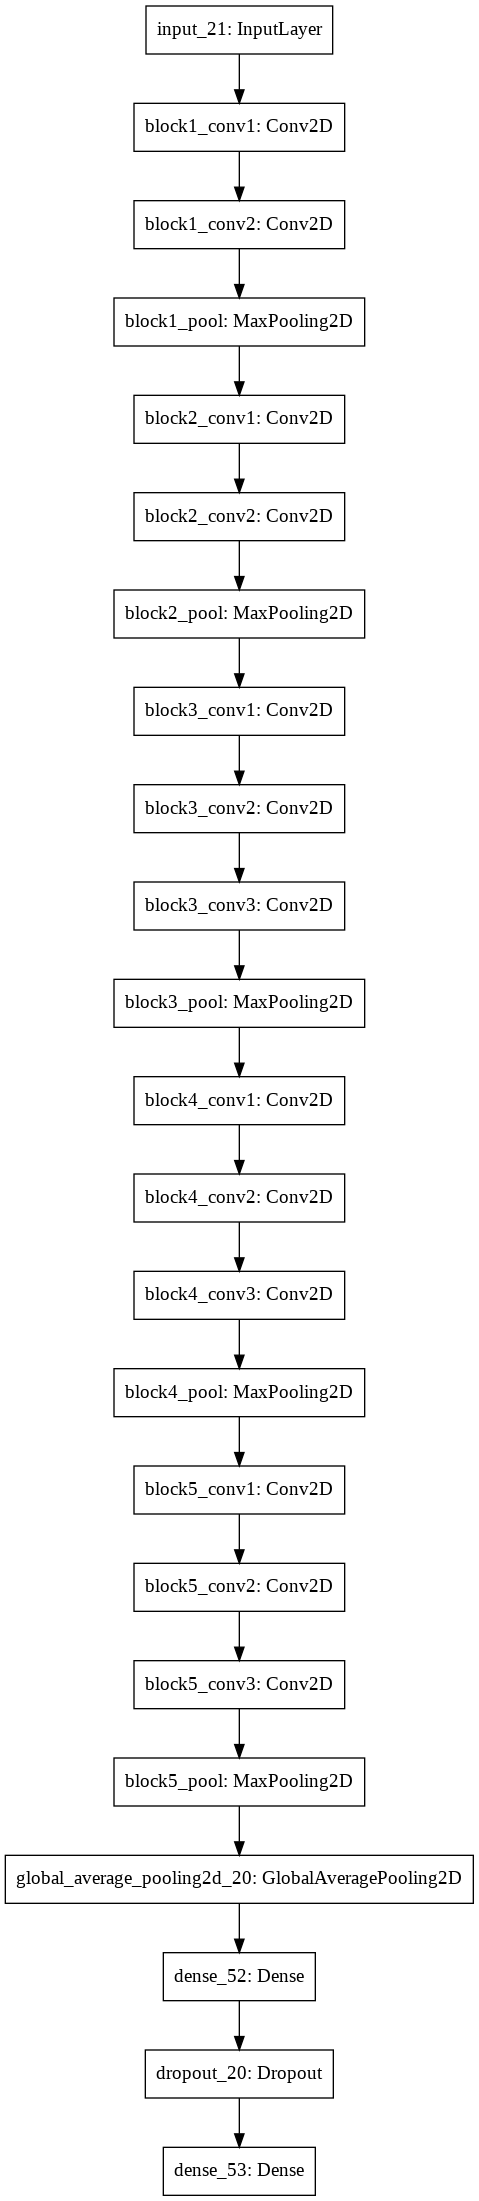

In [ ]:
plot_model(model2)

In [ ]:
from random import shuffle

ind_list = [i for i in range(len(X_train))]
shuffle(ind_list)
X_train_new  = X_train[ind_list, :,:,:]
Y_train_new = Y_train[ind_list]

In [ ]:
r2=model2.fit(X_train_new,Y_train_new,validation_split=0.2,epochs=20, callbacks=[early_stop,reduceLR])


Epoch 1/20
8/8 [==============================] - 1s 137ms/step - loss: 0.2210 - accuracy: 0.9336 - val_loss: 0.1131 - val_accuracy: 0.9688
Epoch 2/20
8/8 [==============================] - 1s 116ms/step - loss: 0.2332 - accuracy: 0.9258 - val_loss: 0.1140 - val_accuracy: 0.9688
Epoch 3/20
8/8 [==============================] - 1s 117ms/step - loss: 0.2045 - accuracy: 0.9492 - val_loss: 0.1143 - val_accuracy: 0.9688
Epoch 4/20
8/8 [==============================] - 1s 115ms/step - loss: 0.2313 - accuracy: 0.9453 - val_loss: 0.1147 - val_accuracy: 0.9688
Epoch 5/20
8/8 [==============================] - 1s 115ms/step - loss: 0.2410 - accuracy: 0.9375 - val_loss: 0.1152 - val_accuracy: 0.9688


In [ ]:
# Predictions on Test Datasets using VGG16 model

test_pred_transfer=np.argmax(model2.predict(X_test),axis=1)
print(classification_report(Y_test,test_pred_transfer))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71        19
           1       0.80      0.50      0.62        16
           2       0.73      0.73      0.73        22
           3       0.64      0.70      0.67        23

    accuracy                           0.69        80
   macro avg       0.70      0.68      0.68        80
weighted avg       0.70      0.69      0.68        80



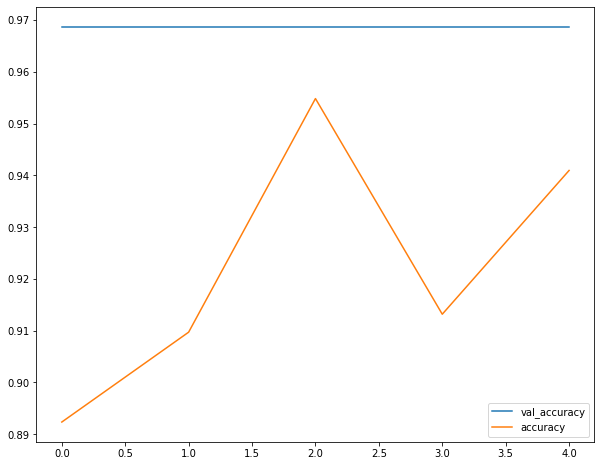

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r2.history['val_accuracy'])
plt.plot(r2.history['accuracy'])
plt.legend(['val_accuracy','accuracy'])
plt.show()

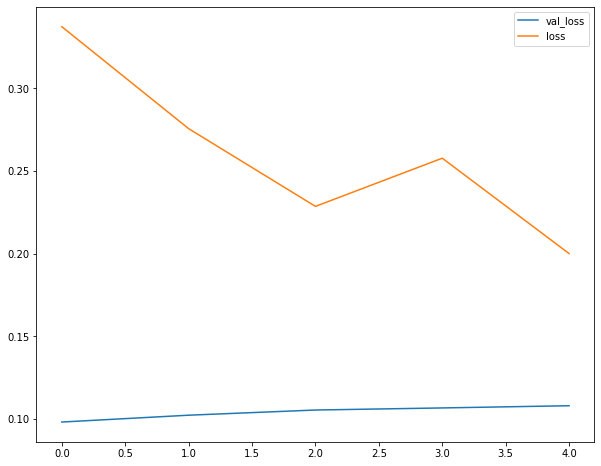

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r2.history['val_loss'])
plt.plot(r2.history['loss'])
plt.legend(['val_loss','loss'])
plt.show()